# SARIMA for Time Series Forecasting...

**Adonis González**

Utilizaremos los datos de la calidad del aire del Eixample de Barcelona desde 2011, concretamente del contaminante dióxido de nitrógeno (NO2). Los datos son medidos por la Red de Vigilancia y Previsión de la Contaminación Atmosférica y se pueden obtener para otras estaciones, contaminantes y períodos aquí.

http://mediambient.gencat.cat/es/05_ambits_dactuacio/atmosfera/qualitat_de_laire/principals_contaminants/index.html

In [1]:
# import libs

In [2]:
import pickle

import scipy.stats
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib as mpl
from sklearn import svm
from sklearn import ensemble
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline

In [3]:
# read csv data

df = pd.read_csv('NO2_Eixample_2011_2019.csv')
print("Number of rows and columns:", df.shape)
print("Column names:", list(df.columns))
df.head(3)

Number of rows and columns: (3214, 40)
Column names: ['codi_eoi', 'nom_estacio', 'data', 'magnitud', 'contaminant', 'unitats', 'tipus_estacio', 'area_urbana', 'codi_ine', 'municipi', 'codi_comarca', 'nom_comarca', 'h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24', 'altitud', 'latitud', 'longitud', 'geocoded_column']


,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,altitud,latitud,longitud,geocoded_column
0,8019043,Barcelona (Eixample),2014-10-03T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,60.0,60.0,36.0,39.0,70.0,70.0,67.0,95.0,97.0,106.0,92.0,86.0,102.0,90.0,84.0,93.0,92.0,68.0,70.0,100.0,95.0,97.0,81.0,69.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
1,8019043,Barcelona (Eixample),2014-09-02T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,26.0,32.0,45.0,48.0,40.0,50.0,47.0,67.0,68.0,67.0,62.0,61.0,62.0,65.0,46.0,49.0,60.0,59.0,70.0,80.0,74.0,61.0,37.0,20.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2,8019043,Barcelona (Eixample),2014-05-16T00:00:00.000,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,25.0,17.0,22.0,25.0,39.0,35.0,46.0,90.0,93.0,59.0,54.0,60.0,64.0,60.0,53.0,50.0,67.0,74.0,76.0,77.0,70.0,75.0,69.0,48.0,26,41.385315,2.1538,POINT (2.1538 41.385315)


Convertimos la columna "data" (=fecha) a tipo datetime y ordenamos los datos temporalmente:

In [4]:
df["data"] = pd.to_datetime(df["data"])
df.sort_values("data", inplace=True)
df.head(3)

,codi_eoi,nom_estacio,data,magnitud,contaminant,unitats,tipus_estacio,area_urbana,codi_ine,municipi,codi_comarca,nom_comarca,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,altitud,latitud,longitud,geocoded_column
2912,8019043,Barcelona (Eixample),2011-01-17,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,115.0,101.0,98.0,87.0,81.0,87.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2704,8019043,Barcelona (Eixample),2011-01-18,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,80.0,81.0,76.0,76.0,71.0,61.0,94.0,115.0,178.0,164.0,158.0,174.0,180.0,133.0,100.0,97.0,99.0,107.0,127.0,141.0,160.0,190.0,194.0,194.0,26,41.385315,2.1538,POINT (2.1538 41.385315)
2805,8019043,Barcelona (Eixample),2011-01-19,8,NO2,µg/m3,traffic,urban,8019,Barcelona,13,Barcelonès,164.0,152.0,142.0,129.0,121.0,136.0,154.0,189.0,164.0,152.0,NaN,NaN,100.0,92.0,87.0,81.0,91.0,104.0,81.0,78.0,82.0,86.0,88.0,102.0,26,41.385315,2.1538,POINT (2.1538 41.385315)


Vemos que, para cada fila, tenemos las medidas de N02 en µg/m3 para cada hora del día. Para simplificar el análisis, utilizaremos solamente la media diaria, que passamos a calcular:

In [5]:
colNs_hourly_measurements = ["h%02d" % h for h in range(1,25)]
print(colNs_hourly_measurements)
df["mean_day"] = df[colNs_hourly_measurements].mean(axis=1)
df[["data", "mean_day"] + colNs_hourly_measurements].head()

['h01', 'h02', 'h03', 'h04', 'h05', 'h06', 'h07', 'h08', 'h09', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24']


,data,mean_day,h01,h02,h03,h04,h05,h06,h07,h08,h09,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
2912,2011-01-17,98.428571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,115.0,101.0,98.0,87.0,81.0,87.0
2704,2011-01-18,127.083333,80.0,81.0,76.0,76.0,71.0,61.0,94.0,115.0,178.0,164.0,158.0,174.0,180.0,133.0,100.0,97.0,99.0,107.0,127.0,141.0,160.0,190.0,194.0,194.0
2805,2011-01-19,117.045455,164.0,152.0,142.0,129.0,121.0,136.0,154.0,189.0,164.0,152.0,NaN,NaN,100.0,92.0,87.0,81.0,91.0,104.0,81.0,78.0,82.0,86.0,88.0,102.0
2969,2011-01-20,71.333333,92.0,88.0,84.0,72.0,74.0,59.0,65.0,65.0,78.0,65.0,62.0,68.0,59.0,58.0,59.0,69.0,73.0,80.0,82.0,70.0,70.0,74.0,67.0,79.0
2831,2011-01-21,75.875000,54.0,41.0,40.0,40.0,31.0,29.0,52.0,88.0,105.0,88.0,74.0,71.0,64.0,79.0,82.0,77.0,86.0,106.0,118.0,120.0,111.0,104.0,92.0,69.0


Hay días, como el primero del conjunto de datos, en los que muchas horas no tienen valores válidos. Esto puede resultar en medias diarias muy desviadas. Por tanto, eliminaremos los días con varias medidas inválidas:

In [6]:
print("Number of rows before:", df.shape[0])
df = df[df[colNs_hourly_measurements].isna().sum(axis=1)<5]
print("Number of rows after:", df.shape[0])

Number of rows before: 3214
Number of rows after: 3146


Representamos la serie temporal, compuesta sólo por la medida media que hemos creado, y como índice la columna que nos indica la fecha:

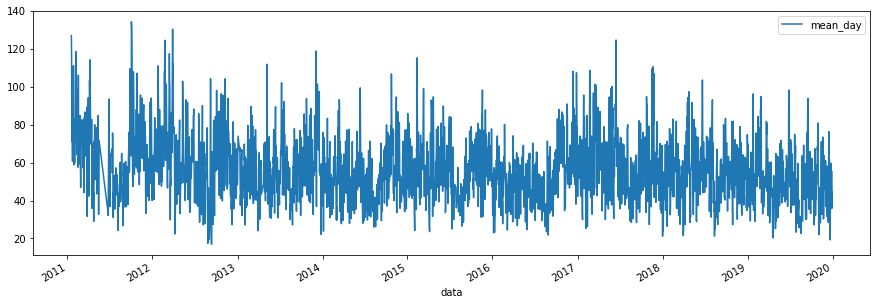

In [7]:
data = df[["data", "mean_day"]].set_index("data")
data.plot(figsize=(15, 5));

Vemos que la variación diaria introduce mucho ruido que no es interesante para analizar la evolución temporal del contaminante en una escala temporal más larga. Por consiguiente, utilizaremos la media de la medida para cada mes en vez de los valores diarios:

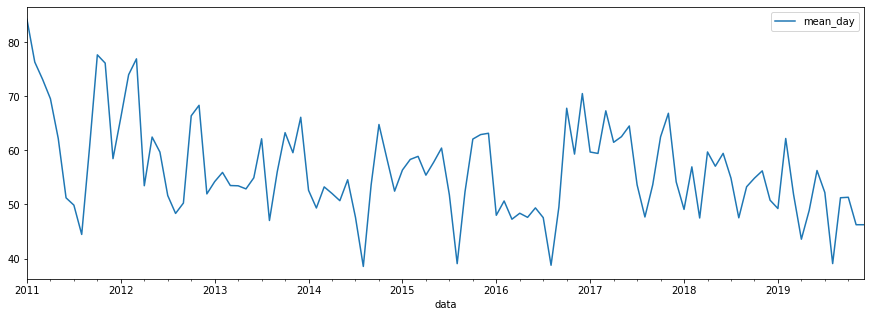

In [8]:
data = df[["data", "mean_day"]].set_index("data").resample("1M").mean()
data.plot(figsize=(15, 5));

Como se puede apreciar, la serie temporal de este contaminante es bastante irregular, pero se intuye cierta heterocedasticidad, tendencia, periodo y ruido, los cuales analizaremos.

<hr></hr>
Antes de empezar a tratar las diferentes componenetes de una serie temporal, eliminaremos del dataset original un par de años de datos. Así cuando hagamos una predicción a futuro podremos comprobar si se ajusta a los datos reales.
<hr></hr>

In [9]:
date_min_test = "2018-01-01"
TEST_SIZE = len(data[data.index>=date_min_test])
# train and test are dataframes that contain the values and a datetime index:
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]

# x_train and x_test only contain the values:
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((84, 1), (84,), (24, 1), (24,))

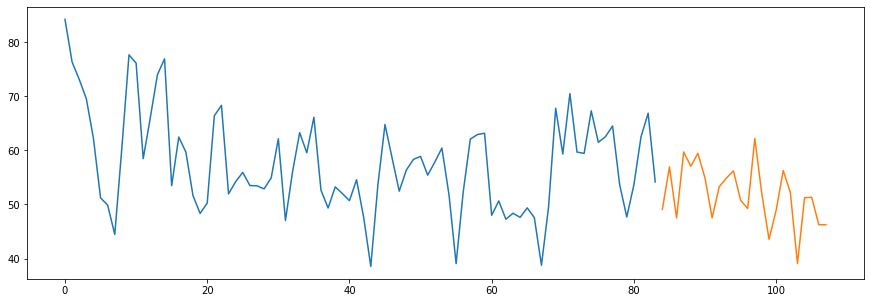

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

Miramos los componentes de la series temporales

### Heterocedasticidad 

Se dice que una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo (https://es.wikipedia.org/wiki/Heterocedasticidad). En nuestro caso, observamos que tenemos una cierta heterocedasticidad, ya que la amplitud de onda disminuye ligeramente con el tiempo. En este apartado se verá diferentes maneras de eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

Primero la **transformación exponencial**

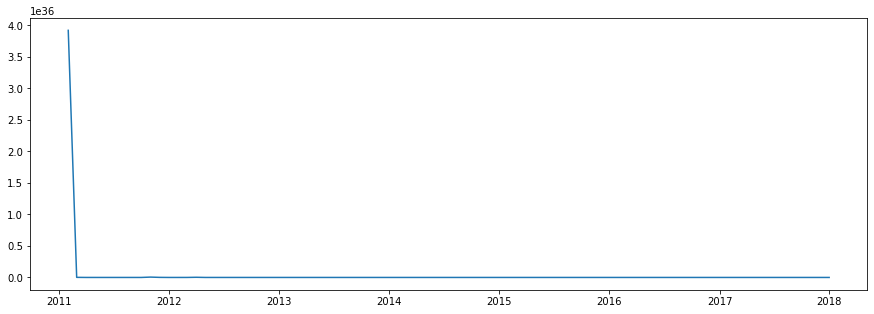

In [11]:
# transformacion exponencial
transExpo = np.exp(train['mean_day'])

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(transExpo)

Miramos la **transformación raíz**

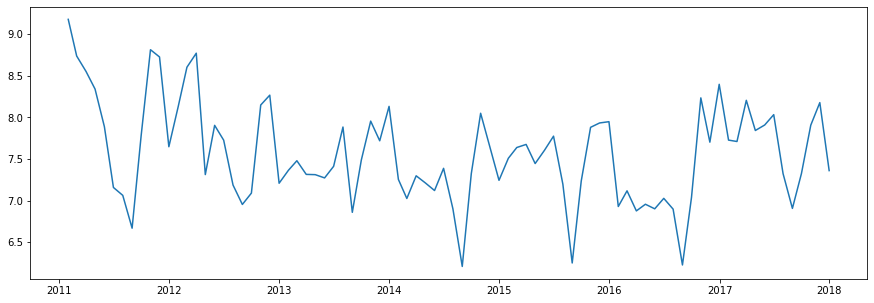

In [12]:
# transformación raiz
trnasSq = np.sqrt(train['mean_day'])

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(trnasSq)

Y también la **transformación logarítmica**

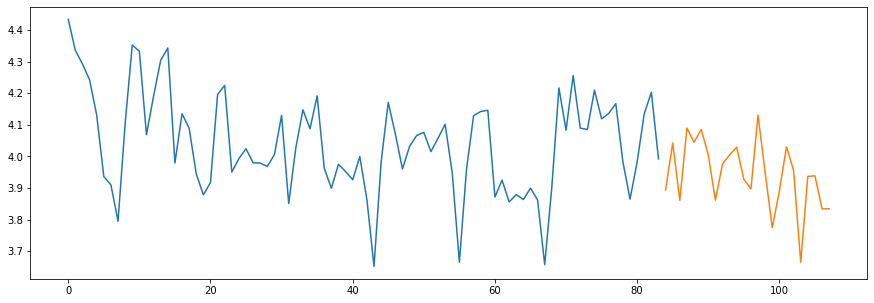

In [13]:
#logaritmica 
# data["log_ret"] = np.log(data["mean_day"]) - np.log(data["mean_day"].iloc[0])
# data["log_ret"] = np.log(data['mean_day']).diff()
data["log_ret"] = np.log(data['mean_day'])
data1 = data[["log_ret"]]

train, test = data1.iloc[:-TEST_SIZE], data1.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data1.shape[0]))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

Después de las diferentes transformaciones nos quedamos con la tranformación logarítmica, es con la que mejor resultado se ha obtenido, se puede observar en la gráfica anterior. Además generamos la serie de test independiente.

### Tendencia

La tendencia es el comportamento que tiene los datos a largo plazo (https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png). En nuestra serie temporal tenemos una ligera tendencia lineal decreciente (mejor para nuestra salud). En este apartado debéis eliminar la tendencia, quedando una serie temporal con tendencia constante.

train = train.fillna(train.mean())
X = x_train
X = np.reshape(X, (len(X), 1))
y = train["log_ret"].tolist()

model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, trend)
ax.plot(x_test, test)
ax.plot(x_train, train)

Esta será la tendencia que asumimos que tienen los datos.


Se ha ajustado una regresión lineal a los datos (con la heterocedasticidad ya eliminada) para examinar la tendencia y se puede apreciar que tenemos una ligera tendencia lineala a la baja. 

Eliminaremos esta tendencia de los datos.

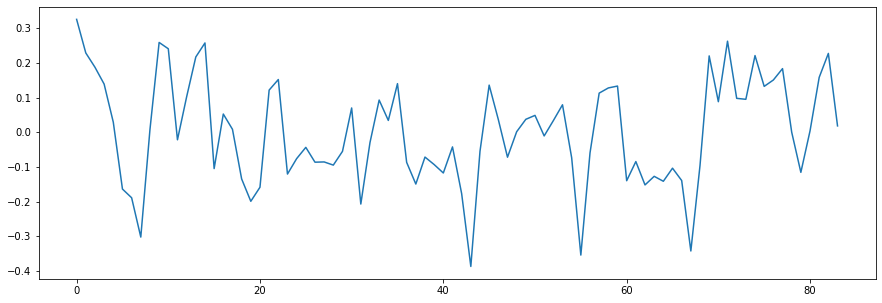

In [15]:
detrended = [y[i]-trend[i] for i in range(0, len(train))]
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(detrended)

### Estacionalidad

Definimos estacionalidad como la variación cíclica que se produce en los datos (https://es.wikipedia.org/wiki/Estacionalidad).

En primer lugar encontraremos el ciclo, es decir, cada cuando se repiten los datos. Para encontrarlo usaremos l'autocorrelación (numpy te permite obtener los coeficientes de correlación). 

In [17]:
# train.diff().plot(figsize=(15,5))
# plt.xlabel('Year', fontsize=20);

# for i in range(1, len(train["log_ret"].tolist())-1):
#     edited = detrended[i:]
#     original = train["log_ret"].tolist()[:-i]
#     r = np.corrcoef(edited, original)
#     print("--------------------------")
#     print("serie "+str(i))
#     print(r)

# Modelo SARIMA

Para tratar la estacionalidad aplicaremos un modelo SARIMA. Las siglas corresponden a "stationality ARIMA", es decir, un modelo ARIMA con estacionalidad (la que acabamos de encontrar).

El modelo ARIMA nos va a permitir tratar el ruido que queda al eliminar la heterocedasticidad, tendencia y estacionalidad. Para hacerlo tiene en cuenta las siguientes componentes:

    - AR: auto-regressive, se denomina p. Tiene en cuenta la correlación con sus lags, es decir, mira si las observaciones pasadas afectan para calcular el siguiente punto.
    
    - I: integrated, se denomina d. Es el orden de diferenciación, en nuestro caso no es necesario, puesto que la serie ya no tiene heterocedasticidad ni tendencia.
    
    - MA: moving-average, se denomina q. Tiene en cuenta la correlación con los lags de los errores, es decir, una vez se ha aplicado el modelo, mira los errores del modelo versus los datos reales.

Para más información sobre los ARIMA podéis consultar este link: https://otexts.com/fpp2/arima.html

Los modelos SARIMA dependen de varios parámetros (p,d,q)(P,D,Q)s, donde los primeros (minúsculas) corresponden a AR, I, MA de la serie normal, u los segundos (mayúsculas) a AR, I, MA con estacionalidad.

Para encontrar estos parámetros tenemos que mirar los gráficos PACF (partial autocorrelation function) y ACF (autocorrelation function).

El gráfico PACF nos determina el parámetro p, es decir, la AR.


In [20]:
# Supongamos que los datos sin heterocedasticidad ni tendencia se llaman train_log_trend
plot_pacf(train_log_trend)
plt.show()

Nada mas empezar hay dos valores fuera del intervalo. De todos modos el primero no se debe tener en cuenta, puesto que mira la correlación de un valor consigo mismo, y esta siempre será 1. Si no tenemos en cuenta este primer valor, en el primer ciclo (primeros 12 puntos) hay tres valores fuera del intervalo de confianza, pero uno de ellos justo en la frontera, con lo cual escogemos p = 2. También podríamos probar con p=1 o p=3.

Cuando se repite el ciclo, es decir, a partir del valor 11, hay tres valores claramente fuera del intervalo, con lo cual P = 3. También podríamos probar con P=2 o p=4.

Veamos ahora el gráfico ACF, este determinará el valor de q.

In [22]:
plot_acf(train_log_trend)
plt.show()



Este gráfico se lee igual que el anterior.

Ignorando el primer lag, vemos que al empezar hay un valor fuera del intervalo, con lo cual q = 1. Cuando se repite el ciclo, es decir, a partir del valor 11, solo hay un valor fuera del intervalo, con lo cual Q = 1.

Como los datos no tienen ni tendencia ni heterocedasticidad, d = D = 0.

Como hemos visto en el apartado anterior, el ciclo es 12, con lo cual s = 12.


**Aplicamos el modelo SARIMA a los datos sin heterocedasticidad ni tendencia.**

In [23]:
my_order =(2, 0, 1)
my_seasonal_order = (2, 0, 1, 12)
model = SARIMAX(detrended, order = my_order, seasonal_order=my_seasonal_order)
results = model.fit()
print(results.summary())

B:\software\miniConda\envs\models\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 12)   Log Likelihood                  64.848
Date:                            Fri, 30 Apr 2021   AIC                           -115.696
Time:                                    23:25:29   BIC                            -98.680
Sample:                                         0   HQIC                          -108.855
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1335      0.672     -0.199      0.843      -1.451       1.184
ar.L2          0.3487      0.422   

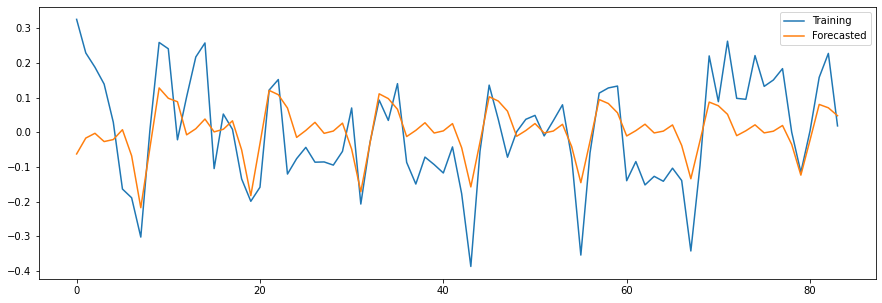

In [24]:
pred_u2 = results.get_forecast(steps=len(train))
actual = detrended
forecasted_EtEs = pred_u2.predicted_mean

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, detrended, label="Training")
# ax.plot(x_test, test, label="Test")
ax.plot(x_train, forecasted_EtEs, label="Forecasted")
# plt.gca().set_aspect('equal', adjustable='box')
ax.legend()
plt.draw()

# Predicción SARIMA

Utilizaremos el modelo SARIMA que hemos fitado antes para predecir los dos próximos años.

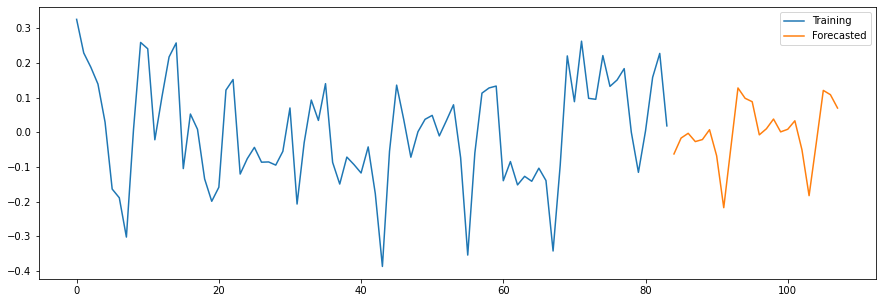

In [25]:
pred_u2 = results.get_forecast(steps=len(test))
actual = detrended
forecasted_last = pred_u2.predicted_mean

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, detrended, label="Training")
# ax.plot(x_test, test, label="Test")
ax.plot(x_test, forecasted_last, label="Forecasted")

ax.legend()
plt.show()